In [70]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
import seaborn as sns

In [78]:
datatemp = 'data/pfas_2023_surf_ground_drink.parquet'
df_temp = pd.read_parquet(datatemp)

In [79]:
df_temp.head()

,lat,lon,pfas_sum
194750,41.392351,9.165047,4.1
194743,41.695461,8.948481,0.0
325551,41.718255,9.303876,0.0
194730,41.754673,8.859828,0.0
325421,41.768722,9.173763,0.0


In [84]:
datatemp = 'data/pfas_france_2023_dist_site_rr.parquet'
df_temp = pd.read_parquet(datatemp)
df_temp = df_temp.drop(columns=["geometry"])

In [85]:
df_temp.head()

,id,lon,lat,POSTE,RR
0,1014002,5.669000,46.278167,1014002,1413.8
1,1034004,5.688000,45.769333,1034004,1179.9
2,1064001,5.487167,45.777167,1064001,1182.6
3,1071001,6.080333,46.310333,1071001,1177.9
4,1072001,5.287667,46.204333,1072001,1042.5


In [4]:
data = 'data/pfas_france_2023_dist_site.parquet'
df_observation = pd.read_parquet(data)

In [5]:
data = 'data/rr_annuel.parquet'
df_rr = pd.read_parquet(data)

In [14]:
print(df_rr.shape)
df_rr.head()

(1968, 6)


,id,lon,lat,geometry,POSTE,RR
0,1014002,5.669000,46.278167,b'\x01\x01\x00\x00\x00\xdd$\xf9b<B#A\x93\xb5\x...,1014002,1413.8
1,1034004,5.688000,45.769333,b'\x01\x01\x00\x00\x00\xb7\xca\xfa\x86\xc2R#A\...,1034004,1179.9
2,1064001,5.487167,45.777167,"b'\x01\x01\x00\x00\x00\x90\x0c\xceE\x19\xa4""A\...",1064001,1182.6
3,1071001,6.080333,46.310333,b'\x01\x01\x00\x00\x00\x8du\x96%\xf7\xa7$A\xb6...,1071001,1177.9
4,1072001,5.287667,46.204333,b'\x01\x01\x00\x00\x00\x1a\xbf\xbc\xcb\x98\xf6...,1072001,1042.5


In [16]:
print(df_observation.shape)
df_observation.head()

(4120, 4)


,lat,lon,pfas_sum,distance_site
194750,41.392351,9.165047,4.1,129.586067
194743,41.695461,8.948481,0.0,93.066029
325551,41.718255,9.303876,0.0,99.050189
194730,41.754673,8.859828,0.0,85.771498
325421,41.768722,9.173763,0.0,89.702452


In [11]:
# Fonction pour calculer la distance entre deux points géographiques
def haversine(lon1, lat1, lon2, lat2):
    R = 6371  # rayon de la Terre en km
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

In [50]:
# Distance seuil pour considérer deux points comme "proches"
distance_threshold = 10.0  # en km (par exemple, 1 km)

In [17]:
# Calcul des distances entre tous les points des deux DataFrames
distances = cdist(df_rr[['lat', 'lon']], df_observation[['lat', 'lon']], metric=lambda u, v: haversine(u[1], u[0], v[1], v[0]))

In [37]:
np.sort(distances[0])[:10]

array([ 3.57324576,  6.29794894,  7.88453385,  8.0997829 , 10.38267042,
       10.49699429, 10.95835456, 12.25886667, 13.03935109, 14.54252825])

In [51]:
# Trouver les paires de points dont la distance est inférieure au seuil
close_pairs = np.where(distances < distance_threshold)

In [52]:
close_pairs[0].shape

(4547,)

In [54]:
# Liste des valeurs des points co-localisés
df_rr_values = []
df_observation_values = []

for i, j in zip(close_pairs[0], close_pairs[1]):
    df_rr_values.append(df_rr.loc[i, 'value'])  # Récupérer la valeur dans df1
    df_observation_values.append(df_observation.loc[j, 'value'])  # Récupérer la valeur dans df2

KeyError: 'value'

In [55]:
# Extraire les coordonnées des observations et des stations météo
coords_observation = df_observation[['lon', 'lat']].to_numpy()
coords_rr = df_rr[['lon', 'lat']].to_numpy()

In [57]:
from scipy.spatial import cKDTree
# Créer un arbre de k-d pour les stations météo (c'est plus rapide pour la recherche)
tree = cKDTree(coords_rr)

In [58]:
# Pour chaque observation, trouver la station la plus proche
# Distances correspond aux distances les plus proches, indices correspond aux indices des stations les plus proches
distances, indices = tree.query(coords_observation, k=1)  # k=1 pour trouver la station la plus proche

In [60]:
# Ajouter les distances et les quantités de pluie associées aux observations
df_observation['closest_rr_station'] = df_rr.loc[indices, 'id'].values
df_observation['closest_rr'] = df_rr.loc[indices, 'RR'].values
df_observation['distance_to_rr_station'] = distances

In [66]:
np.sort(df_observation["distance_to_rr_station"])[::-1]

array([0.3015818 , 0.28811262, 0.27691765, ..., 0.00062236, 0.00051736,
       0.00042137])

In [86]:
df_observation

,lat,lon,pfas_sum,distance_site,closest_rr_station,closest_rr,distance_to_rr_station
194750,41.392351,9.165047,4.1,129.586067,20041001,596.3,0.021986
194743,41.695461,8.948481,0.0,93.066029,20249003,528.0,0.037684
325551,41.718255,9.303876,0.0,99.050189,20092001,817.6,0.044642
194730,41.754673,8.859828,0.0,85.771498,20232002,884.4,0.074170
325421,41.768722,9.173763,0.0,89.702452,20362005,1197.3,0.021627
...,...,...,...,...,...,...,...
159310,50.787268,1.975412,0.0,13.558927,62076002,1647.1,0.077803
159329,50.798708,2.143868,0.0,8.785299,59647001,1205.1,0.077841
159250,50.834486,1.686862,0.0,13.321825,62054001,978.3,0.109817
159292,50.894631,1.839508,0.0,4.803427,62548002,947.5,0.133644


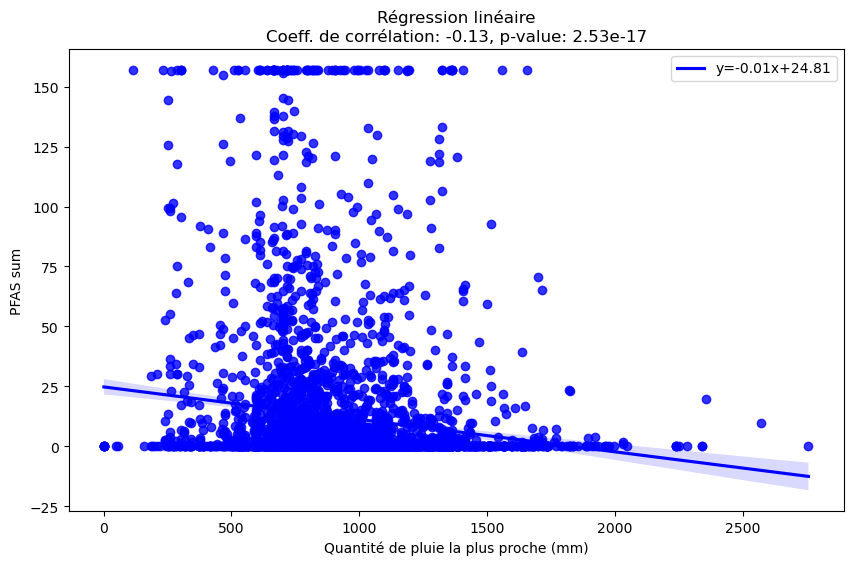

In [71]:
from scipy.stats import linregress
import seaborn as sns
import matplotlib.pyplot as plt

# Calcul de la corrélation linéaire entre pfas_sum et closest_rr
corr_coef = df_observation['closest_rr'].corr(df_observation['pfas_sum'])

# Régression linéaire
slope, intercept, r_value, p_value, std_err = linregress(df_observation['closest_rr'], df_observation['pfas_sum'])

# Plot des données avec la régression linéaire
plt.figure(figsize=(10, 6))
sns.regplot(x='closest_rr', y='pfas_sum', data=df_observation, line_kws={'label': f"y={slope:.2f}x+{intercept:.2f}"}, color='blue')
plt.xlabel('Quantité de pluie la plus proche (mm)')
plt.ylabel('PFAS sum')
plt.title(f"Régression linéaire\nCoeff. de corrélation: {corr_coef:.2f}, p-value: {p_value:.2e}")
plt.legend()
plt.show()
